In [1]:
from pathlib import Path

# Check package versions
import numpy as np
import astropy.units as u
from astropy.io import fits
from astropy.coordinates import Angle, SkyCoord
from regions import CircleSkyRegion

# %matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from IPython.display import display
from gammapy.data import DataStore
from gammapy.datasets import (
    Datasets,
    FluxPointsDataset,
    SpectrumDataset,
    SpectrumDatasetOnOff,
)
from gammapy.estimators import FluxPointsEstimator
from gammapy.makers import (
    ReflectedRegionsBackgroundMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
)
from gammapy.maps import Map, MapAxis, RegionGeom, WcsGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    create_crab_spectral_model,
)
from gammapy.visualization import plot_spectrum_datasets_off_regions

In [3]:
datastore = DataStore.from_dir("/raid/RAID1/VERITAS_Data/gammapy/LS5039/")

observations = datastore.get_observations()

In [4]:
target_position = SkyCoord.from_name("LS 5039")
on_region_radius = Angle("0.089 deg")
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

In [5]:
energy_axis = MapAxis.from_energy_bounds(
    0.5, 20, nbin=5, per_decade=True, unit="TeV", name="energy"
)
energy_axis_true = MapAxis.from_energy_bounds(
    0.1, 100, nbin=20, per_decade=True, unit="TeV", name="energy_true"
)

geom = RegionGeom.create(region=on_region, axes=[energy_axis])

In [6]:
geom_image = geom.to_wcs_geom()

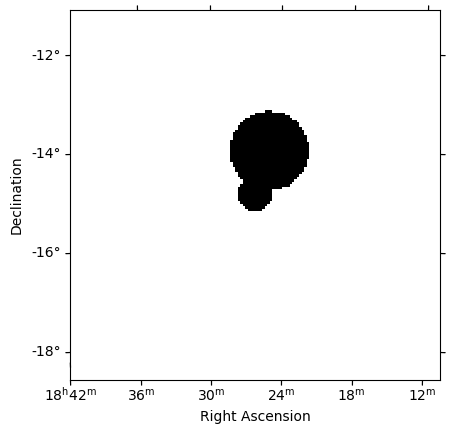

In [7]:
# get the geom that we use

# Make the exclusion mask
regions = CircleSkyRegion(center=target_position, radius=0.35 * u.deg)
region_hess = CircleSkyRegion(center=SkyCoord(276.26  * u.deg, -13.97* u.deg, frame = "fk5"), radius=0.8 * u.deg)

all_ex = [regions, region_hess]
# stars = []
# for star in srcs_tab:
#     pos = SkyCoord(star["RA"], star["DEC"], frame="fk5", unit=(u.hourangle, u.deg))
#     star = CircleSkyRegion(center=pos, radius=0.3 * u.deg)
#     stars.append(star)
#     all_ex.append(star)

# geom_image = geom.to_wcs_geom()
skydir = target_position.galactic
geom_image = WcsGeom.create(
    npix=(150, 150), binsz=0.05, skydir=skydir, proj="TAN", frame="icrs"
)
exclusion_mask = ~geom_image.region_mask(all_ex)
exclusion_mask.sum_over_axes().plot()


source_only_mask = ~geom_image.region_mask([regions])
exclusion_mask.write("exclusion_mask.fits", overwrite="True")

plt.show()

In [8]:
exclusion_mask

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat']
	shape : (150, 150)
	ndim  : 2
	unit  : 
	dtype : bool

In [9]:

dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

dataset_maker = SpectrumDatasetMaker(
    containment_correction=True, selection=["counts", "exposure", "edisp"]
)
bkg_maker = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask)
safe_mask_masker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

In [10]:
obs_ids = observations.ids
print(observations[0])

Observation

	obs id            : 69054 
 	tstart            : 56451.43
	tstop             : 56451.45
	duration          : 2050.00 s
	pointing (icrs)   : 276.6 deg, -14.3 deg

	deadtime fraction : 9.2%



In [11]:
datasets = Datasets()

for obs_id, observation in zip(obs_ids, observations):
    print (obs_id)
    dataset = dataset_maker.run(dataset_empty.copy(name=str(obs_id)), observation)
    dataset_on_off = bkg_maker.run(dataset, observation)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, observation)
    datasets.append(dataset_on_off)

print(datasets)

69054
69123
69187
69188
69202
69203
73193
73213
73234
73300
73317
73335
73356
73357
73390
73403
73607
Datasets
--------

Dataset 0: 

  Type       : SpectrumDatasetOnOff
  Name       : 69054
  Instrument : VERITAS
  Models     : 

Dataset 1: 

  Type       : SpectrumDatasetOnOff
  Name       : 69123
  Instrument : VERITAS
  Models     : 

Dataset 2: 

  Type       : SpectrumDatasetOnOff
  Name       : 69187
  Instrument : VERITAS
  Models     : 

Dataset 3: 

  Type       : SpectrumDatasetOnOff
  Name       : 69188
  Instrument : VERITAS
  Models     : 

Dataset 4: 

  Type       : SpectrumDatasetOnOff
  Name       : 69202
  Instrument : VERITAS
  Models     : 

Dataset 5: 

  Type       : SpectrumDatasetOnOff
  Name       : 69203
  Instrument : VERITAS
  Models     : 

Dataset 6: 

  Type       : SpectrumDatasetOnOff
  Name       : 73193
  Instrument : VERITAS
  Models     : 

Dataset 7: 

  Type       : SpectrumDatasetOnOff
  Name       : 73213
  Instrument : VERITAS
  Models     : 


/home/obriens/mambaforge/envs/gammapy-tools/lib/python3.11/site-packages/regions/shapes/circle.py:161: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Circle(xy=xy, radius=radius, **mpl_kwargs)


<WCSAxes: >

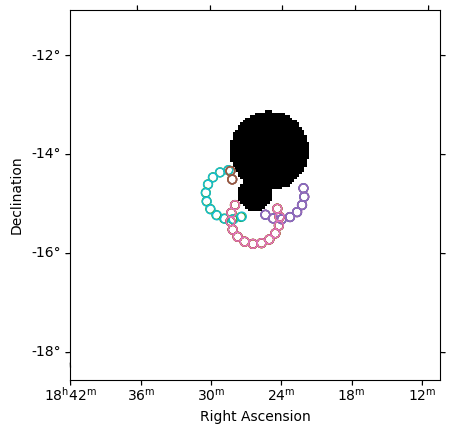

In [12]:
plt.figure()
ax = exclusion_mask.plot()
on_region.to_pixel(ax.wcs).plot(ax=ax, edgecolor="k")
plot_spectrum_datasets_off_regions(ax=ax, datasets=datasets)

In [13]:
info_table = datasets.info_table(cumulative=True)

print(
    f"Tobs={info_table['livetime'].to('h')[-1]:.1f} Excess={info_table['excess'].value[-1]:.1f} \
Significance={info_table['sqrt_ts'][-1]:.2f}"
)
display(info_table)

Tobs=6.5 h Excess=142.6 Significance=13.13


name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str7,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,12,9.0,2.8840537732017664,3.0,6.0,6.0,nan,7341.82373046875,634207872.0,1861.1053128409444,2050.000000000001,0.006447781282017949,0.0016119453205044871,0.004835835961513462,9,8,wstat,16.12638531504644,6,8.0,16.0,0.5
stacked,29,23.230770111083984,6.1140469924133765,5.769230842590332,8.35971817723599,8.35971817723599,nan,2101.2197265625,1128683648.0,3483.612719621822,3853.0000000000045,0.008324691156584196,0.001656105688813949,0.0066685857415303895,9,9,wstat,57.593165334884,42,9.0,65.5199966430664,0.13736264407634735
stacked,39,28.77622413635254,6.275170152498236,10.223775863647461,12.926352157971797,12.926352157971797,nan,0.008562149479985237,1604763904.0,5140.782454499988,5656.000000000004,0.007586393772773116,0.001988758706312902,0.005597635066460214,9,9,wstat,63.82009984192804,91,9.0,80.10739135742188,0.11234918236732483
stacked,50,35.651222229003906,6.711727567645557,14.348775863647461,17.925175918969114,17.925175918969114,nan,0.008562149479985237,2108660096.0,6807.666734664915,7459.000000000003,0.007344660358504034,0.0021077377055758197,0.0052369223727516566,9,9,wstat,62.894103273170494,124,9.0,77.77667236328125,0.11571593582630157
stacked,78,56.151222229003906,8.280469152936611,21.848777770996094,28.907486727848774,28.907486727848774,nan,0.024162599816918373,2568878592.0,8402.875374843057,9262.000000000002,0.009282536812758195,0.0026001549227313357,0.00668238189002686,9,9,wstat,97.44144474714864,139,9.0,57.25720977783203,0.15718545019626617
stacked,96,69.76660919189453,9.467708849133512,26.2333927154541,34.045802642368926,34.045802642368926,nan,0.024162599816918373,3056991232.0,9990.22946465885,11065.0,0.009609388887373093,0.0026259049212289465,0.00698348415706555,9,9,wstat,118.42840834619868,196,9.0,67.24253845214844,0.13384383916854858
stacked,101,71.01660919189453,9.230059271499172,29.9833927154541,37.8700257863507,37.8700257863507,nan,659.0110473632812,3317519360.0,10924.321054527454,12147.000000000004,0.009245425825172153,0.0027446458746310685,0.006500780125137621,9,9,wstat,115.75488329908075,226,9.0,67.83755493164062,0.13266988098621368
stacked,112,79.0166015625,9.710218606892182,32.983394622802734,42.11905272304626,42.11905272304626,nan,343.8702392578125,3810549760.0,12744.022326494665,14248.000000000004,0.008788434069764095,0.002588146330709941,0.006200287439721873,9,9,wstat,134.07438849137964,232,9.0,63.30458068847656,0.1421698033809662


Text(0, 0.5, 'Sqrt(TS)')

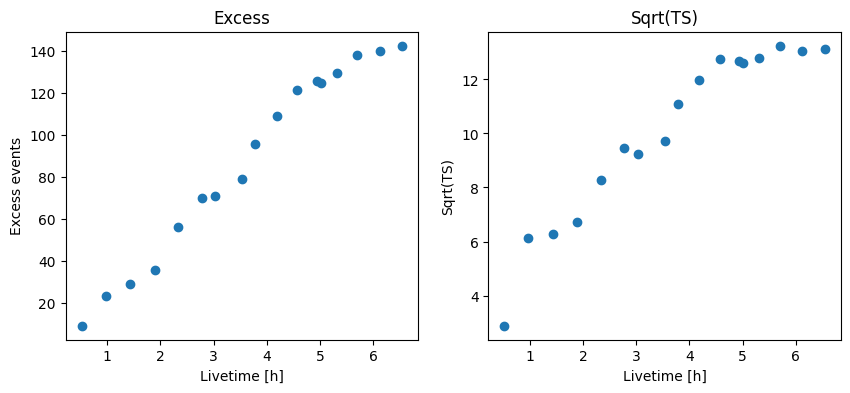

In [14]:
fig, (ax_excess, ax_sqrt_ts) = plt.subplots(figsize=(10, 4), ncols=2, nrows=1)
ax_excess.plot(
    info_table["livetime"].to("h"),
    info_table["excess"],
    marker="o",
    ls="none",
)

ax_excess.set_title("Excess")
ax_excess.set_xlabel("Livetime [h]")
ax_excess.set_ylabel("Excess events")

ax_sqrt_ts.plot(
    info_table["livetime"].to("h"),
    info_table["sqrt_ts"],
    marker="o",
    ls="none",
)

ax_sqrt_ts.set_title("Sqrt(TS)")
ax_sqrt_ts.set_xlabel("Livetime [h]")
ax_sqrt_ts.set_ylabel("Sqrt(TS)")

In [15]:
path = Path("spectrum_analysis_LS5039")
path.mkdir(exist_ok=True)

for dataset in datasets:
    dataset.write(filename=path / f"obs_{dataset.name}.fits.gz", overwrite=True)

In [16]:
spectral_model = PowerLawSpectralModel(
    amplitude=1e-12 * u.Unit("cm-2 s-1 TeV-1"),
    index=2,
    reference=1 * u.TeV,
)
model = SkyModel(spectral_model=spectral_model, name="LS5039")

datasets.models = [model]

fit_joint = Fit()
result_joint = fit_joint.run(datasets=datasets)

# we make a copy here to compare it later
model_best_joint = model.copy()

In [17]:
print(result_joint)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully..
	nfev       : 52
	total stat : 153.34

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [18]:
display(result_joint.models.to_parameters_table())

model,type,name,value,unit,error,min,max,frozen,is_norm,link
str6,str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
LS5039,spectral,index,2.2892e+00,,1.300e-01,nan,nan,False,False,
LS5039,spectral,amplitude,2.3848e-12,TeV-1 s-1 cm-2,2.745e-13,nan,nan,False,True,
LS5039,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,


<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='$\\mathrm{}$'>

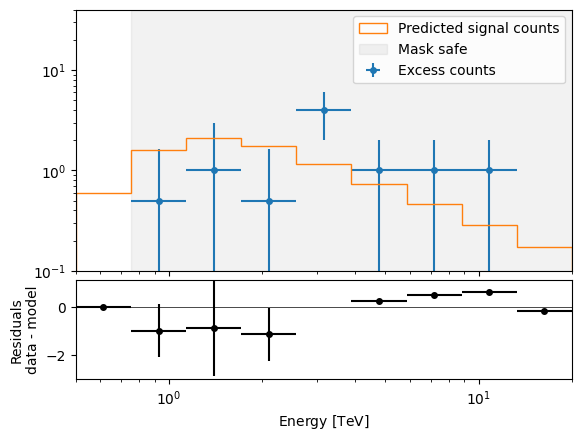

In [19]:
plt.figure()
ax_spectrum, ax_residuals = datasets[0].plot_fit()
ax_spectrum.set_ylim(0.1, 40)
datasets[0].plot_masks(ax=ax_spectrum)

In [20]:
e_min, e_max = 0.5, 20
energy_edges = np.geomspace(e_min, e_max, 10) * u.TeV

In [21]:
fpe = FluxPointsEstimator(
    energy_edges=energy_edges, source="LS5039", selection_optional="all"
)
flux_points = fpe.run(datasets=datasets)

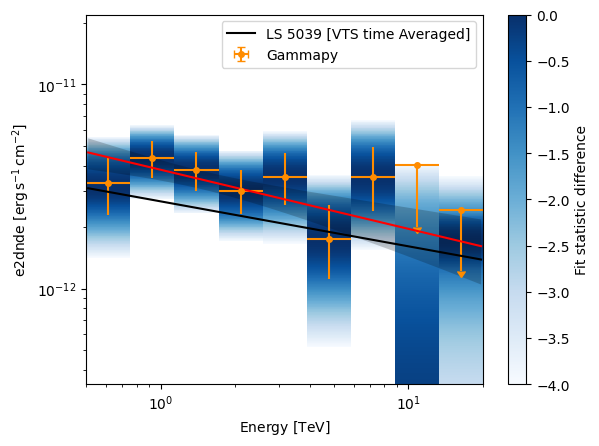

In [22]:
fig, ax = plt.subplots()

erange = (0.5, 20) * u.TeV

flux_points.plot(ax=ax, sed_type="e2dnde", color="darkorange", label = "Gammapy")
flux_points.plot_ts_profiles(ax=ax, sed_type="e2dnde")
spectral_model.plot(erange, 
                    sed_type="e2dnde",
                   color = "r")

spectral_model.plot_error(erange, 
                    sed_type="e2dnde")


model_ls5039_tevcat = PowerLawSpectralModel(
    amplitude = 1.67e-12 / u.TeV / u.cm / u.cm /u.s,
    index = 2.22,
    reference = 1.0 * u.TeV
)
model_ls5039_tevcat.plot(
    energy_bounds = erange,
    label = "LS 5039 [VTS time Averaged]", sed_type = "e2dnde",
    color = "k"
)
plt.legend()